In [1]:
import glob
import pims
import trackpy as tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
import bmc

# Microscope Data

In [2]:
# um_per_px for each zoom
x10 = 9.51/13
x20 = 9.51/24
x40 = 9.51/57

# Bead Data

In [3]:
def bead_path(viscosity, solute, size, magnification):
    path = "../data/beads/%s_visc_%s_%s_um-%s*"%(viscosity, solute, size, magnification)
    return glob.glob(path)

In [4]:
bead_path("13.2", "PVP", "0.4", "40")

['../data/beads/13.2_visc_PVP_0.4_um-40x-2',
 '../data/beads/13.2_visc_PVP_0.4_um-40x']

# Onion Data

In [5]:
onion_both = "../data/onion_1/Onion-cytoplasm-20x-3/*.bmp"
onion_tri = "../data/onion_2/Onion_bulk_20x/*.bmp"

# Velo

In [6]:
test_path = onion_tri
test_frames = pims.as_gray(pims.open(test_path))

test_f = tp.batch(test_frames, diameter=9, minmass=132, maxsize=3)
test_t = tp.link(test_f, search_range=10, memory=3)
test_t.head()

Frame 357: 25 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,5.732875,88.765092,540.737228,1.836021,0.053995,43.130433,6126.9058,0.238771,0,0
28,185.119352,22.603581,198.399990,1.769063,0.159411,14.715089,8003.8252,0.080846,0,1
27,158.047079,7.898940,686.196727,2.422117,0.334792,33.320373,10250.5033,0.045122,0,2
26,152.168783,193.426438,226.477056,1.991955,0.076918,15.560784,5504.4689,0.677942,0,3
25,152.198118,28.536404,341.491543,2.226189,0.285273,20.634952,7043.6835,0.122188,0,4


In [7]:
particle = 0
particle_test_tab = test_t[test_t["particle"] == particle]

In [8]:
test_x_disp = np.diff(particle_test_tab['x'].values)
test_y_disp = np.diff(particle_test_tab['y'].values)
test_r_disp = np.sqrt(test_x_disp**2 + test_y_disp**2)

In [9]:
test_fps = 24
test_px_conv = 0.39625

In [10]:
test_velo = test_r_disp * test_fps / test_px_conv

In [11]:
np.mean(test_velo)

28.329906471241305

In [12]:
np.std(test_velo)

94.72677149668681

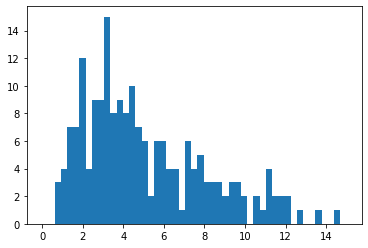

In [13]:
_=plt.hist(test_velo, bins=np.linspace(0,15))

In [14]:
def particle_tab(path, particle_index=0, diameter=11, minmass=250, maxsize=3):
    frames = pims.as_gray(pims.open(path))
    f = tp.batch(frames, diameter=diameter, minmass=minmass, maxsize=maxsize)
    t = tp.link(f, search_range=10, memory=3)
    particle_tab = t[t["particle"] == particle_index]
    return particle_tab

tab_0 = particle_tab(onion_tri, 0, 9, 132, 3)

Frame 357: 25 trajectories present.


In [15]:
def particle_velo(table, px, fps):
    """returns average velocity in microns per second"""
    x_disp = np.diff(table['x'].values)
    y_disp = np.diff(table['y'].values)
    r_disp = np.sqrt(x_disp**2 + y_disp**2)
    velo = r_disp * fps / px
    return np.mean(velo), np.std(velo)

particle_velo(tab_0, 0.39625, 24)

(28.329906471241305, 94.72677149668681)

In [16]:
def diff_coeff(table, px, fps):
    t_filter = tp.filter_stubs(table, threshold=25)
    d = tp.compute_drift(t_filter)
    tm = tp.subtract_drift(t_filter.copy(), d)
    em = tp.emsd(tm, px, fps)
    fits = tp.utils.fit_powerlaw(em, plot=False)
    return fits["A"][0]/4

onion_coeff = diff_coeff(tab_0, 0.39625, 24)

In [17]:
def visc(r, D):
    kT = c.k_B*300*u.K
    D = D*(u.um**2 / u.s)
    r = r*(u.um)
    return (kT / (6*np.pi*D*r)).to(u.mPa * u.s)

In [18]:
tab_0.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,5.732875,88.765092,540.737228,1.836021,0.053995,43.130433,6126.9058,0.238771,0,0
29,5.763265,88.753532,558.930869,1.827661,0.051850,44.749567,6179.3734,0.234221,1,0
57,5.734891,88.775078,570.332669,1.833999,0.051747,45.306801,6227.1750,0.213317,2,0
88,5.719938,88.760433,597.979796,1.840217,0.050954,47.135965,6283.9417,0.196095,3,0
119,5.741995,88.746921,588.262720,1.841302,0.045192,46.003304,6246.4903,0.210106,4,0


Text(0.5, 1.0, 'raw_mass histogram')

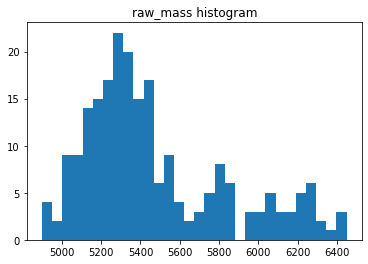

In [19]:
col_name = "raw_mass"

plt.figure()
_ = plt.hist(tab_0[col_name], bins=30)
plt.title("%s histogram"%col_name)